In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [7]:
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')


In [8]:
train = pd.read_csv("../Minor Project/train.csv")
test = pd.read_csv("../Minor Project/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

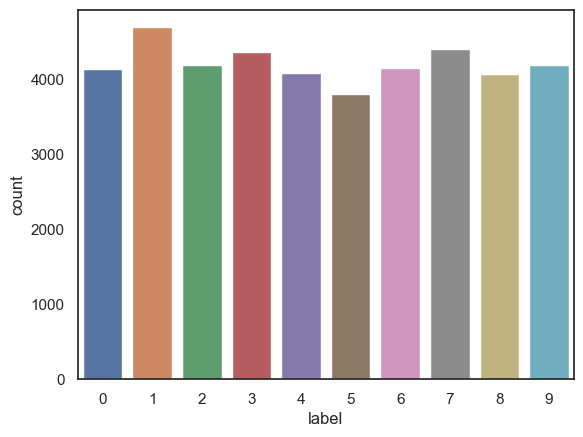

In [9]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(x=Y_train)

Y_train.value_counts()

In [10]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [12]:
X_train = X_train/255.0
test = test/255.0

In [13]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [14]:
Y_train = to_categorical(Y_train, num_classes=10)

In [15]:
random_seed = 2

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size= 0.1, random_state=random_seed)

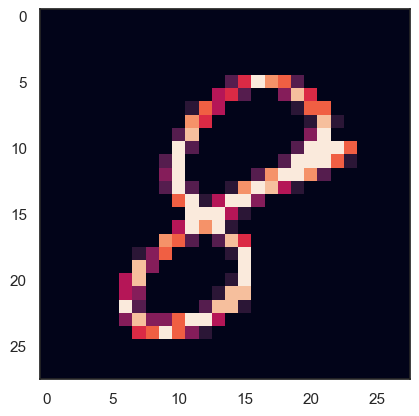

In [17]:
g = plt.imshow(X_train[0][:,:,0])

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size= (5,5), padding='Same', activation='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters=32, kernel_size= (5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding= 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [19]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [20]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [22]:
epochs = 30
batch_size = 86

In [23]:
##history = model.fit(X_train, Y_train, batch_size= batch_size, epochs=epochs, validation_data=(X_val,Y_val), verbose=1)

In [24]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

In [25]:
from keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=1,verbose=1, mode='auto')
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, earlystopper])

Epoch 1/30
439/439 - 13s - loss: 0.4371 - accuracy: 0.8594 - val_loss: 0.0874 - val_accuracy: 0.9733 - lr: 0.0010 - 13s/epoch - 29ms/step
Epoch 2/30
439/439 - 10s - loss: 0.1461 - accuracy: 0.9564 - val_loss: 0.0532 - val_accuracy: 0.9826 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 3/30
439/439 - 9s - loss: 0.1124 - accuracy: 0.9655 - val_loss: 0.0462 - val_accuracy: 0.9857 - lr: 0.0010 - 9s/epoch - 21ms/step
Epoch 4/30
439/439 - 9s - loss: 0.0930 - accuracy: 0.9722 - val_loss: 0.0326 - val_accuracy: 0.9886 - lr: 0.0010 - 9s/epoch - 20ms/step
Epoch 5/30
439/439 - 9s - loss: 0.0846 - accuracy: 0.9750 - val_loss: 0.0431 - val_accuracy: 0.9879 - lr: 0.0010 - 9s/epoch - 20ms/step
Epoch 5: early stopping


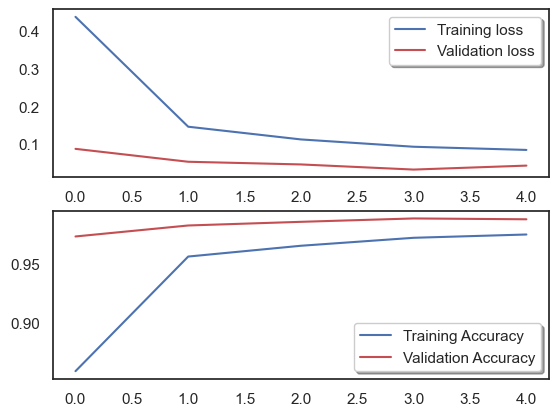

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes = ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

132/132 [==============================] - 0s 3ms/step


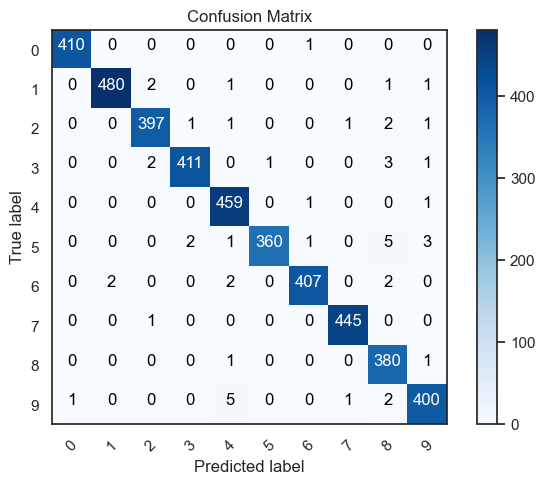

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j , i, cm[i,j],
                 horizontalalignment = "center",
                 color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(10))     

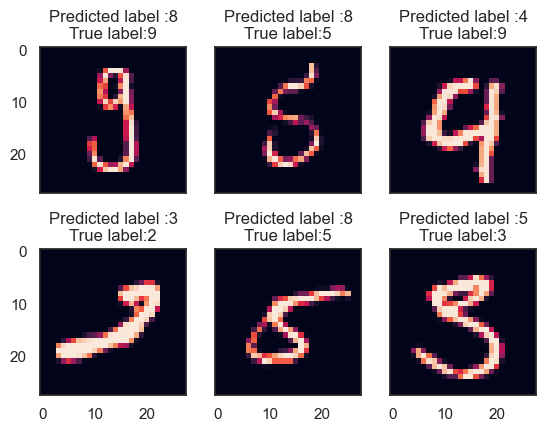

In [28]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex = True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label:{}".format(pred_errors[error], obs_errors[error]))
            n+=1
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors,Y_true_errors, axis = 1))

delta_pred_true_errors = Y_pred_errors_prob = true_prob_errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_delta_errors[-6:]
display_errors(most_important_errors, X_val_errors,Y_pred_classes_errors, Y_true_errors)

In [29]:
results = model.predict(test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name="Label")

875/875 [==============================] - 3s 3ms/step


In [31]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageID"), results], axis = 1)
submission.to_csv("mnist_datagen.csv", index= False)
